### English-French Neural Machine Translation

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR

from matplotlib import pyplot as plt
%matplotlib inline

In [44]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [45]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
device

device(type='mps')

In [11]:
src_language = 'eng'
target_language = 'fra'

In [12]:
# Read the file and split into lines
with open('data/%s-%s.txt' % (src_language, target_language), encoding='utf-8') as file:
    text_data = file.read().splitlines()
print(text_data[:5])

['Go.\tVa !', 'Run!\tCours\u202f!', 'Run!\tCourez\u202f!', 'Wow!\tÇa alors\u202f!', 'Fire!\tAu feu !']


The text is in Unicode. So, we will take the following preprocessing steps:
1. Turn Unicode characters to ASCII
2. lowercase
3. Trim most punctuation

In [13]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(sent):
    return ''.join(
        c for c in unicodedata.normalize('NFD', sent)
        if unicodedata.category(c) != 'Mn'
    )

def preprocess_string(sent):
    "lowercase, unicode_to_ascii, trim, and remove non-letter characters"
    sent = sent.lower().strip()
    sent = unicode_to_ascii(sent)
    # The backreference \1 (backslash one) references the first capturing group. 
    # space followed by \1 matches the exact same text that was matched by the first capturing group [.!?].
    sent = re.sub(r"([.!?])", r" \1", sent)
    # replace character which are not from this set (a-zA-Z.!?) by single space character
    sent = re.sub(r"[^a-zA-Z.!?]+", r" ", sent)
    return sent.strip()

In [14]:
preprocess_string(text_data[3])
print(text_data[3])
print(text_data[3].split('\t')[::-1])

Wow!	Ça alors !
['Ça alors\u202f!', 'Wow!']


In [15]:
def load_data(file_name, reverse=False):
    print("Reading text file...")

    # Read the file and split into lines
    with open('data/%s' % (file_name), encoding='utf-8') as file:
        lines = file.read().splitlines()

    # Split every line into pairs [src_lang, target_lang] and preprocess
    pairs = [[preprocess_string(s) for s in line.split('\t')] for line in lines]

    if reverse:
        pairs = [p[::-1] for p in pairs]
        
    return pairs

In [16]:
pairs = load_data('eng-fra.txt', reverse=False)

Reading text file...


In [17]:
SOS_token = 0
EOS_token = 1
UNK = 2
PAD = 3
BLOCK_SIZE = 12

class Language:
    def __init__(self, lang_name, src=True):
        self.lang_name = lang_name
        self.word_to_index = {"SOS":0, "EOS":1, "UNK": 2, "PAD":3}
        self.index_to_word = {0: "SOS", 1: "EOS", 2: "UNK", 3:"PAD"}
        self.word_to_count = {}
        self.vocab_size = 4
        self.src = src

    def add_word(self, word):
        if word not in self.word_to_index:
            self.word_to_index[word] = self.vocab_size
            self.index_to_word[self.vocab_size] = word
            self.vocab_size += 1
        self.word_to_count[word] = self.word_to_count.get(word, 0) + 1

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def sentence_to_indexes(self, sentence):
        idxs = [self.word_to_index[word] if word in self.word_to_index else self.word_to_index["UNK"] for word in sentence.split(' ')]
        return idxs
        
    def indexes_to_sentence(self, indexes):
        return ' '.join([self.index_to_word[index] for index in indexes])

    def sentence_to_tensor(self, sentence):
        indexes = self.sentence_to_indexes(sentence)
        indexes = [SOS_token] + indexes + [EOS_token]

        max_len = BLOCK_SIZE if self.src else BLOCK_SIZE + 1
        
        if len(indexes) < max_len:
            indexes += [PAD]*(max_len-len(indexes))
        else:
            indexes = indexes[:max_len]
            
        indexes = torch.tensor(indexes, dtype=torch.long)
        return indexes

    def tensor_to_sentence(self, idx_tensor):
        if len(idx_tensor.shape) > 1:
            idxs = idx_tensor.tolist()[0]
        else:
            idxs = idx_tensor.tolist()
        sentence = self.indexes_to_sentence(idxs)
        return sentence

In [18]:
# create language instances
src_lang = Language(src_language)
target_lang = Language(target_language)

for src, target in pairs:
    src_lang.add_sentence(src)
    target_lang.add_sentence(target) 

Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [19]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p, reverse=False):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1 if reverse else 0].startswith(eng_prefixes)


def filterPairs(pairs, reverse):
    return [pair for pair in pairs if filterPair(pair, reverse)]

The full process for preparing the data is:

Read text file and split into lines, split lines into pairs

Normalize text, filter by length and content

Make word lists from sentences in pairs

In [20]:
def create_dataset(src_lang, target_lang, reverse=False):
    pairs = load_data('eng-fra.txt', reverse)

    # create language instances
    input_lang = Language(src_lang)
    output_lang = Language(target_lang, src=False)

    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs, reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))

    # train/val/test split
    n_total = len(pairs)
    n_train = int(0.8*n_total)
    n_val = int(0.1*n_total)
    n_test = n_total - n_train - n_val
    print(f"{n_train=}, {n_val=}, {n_test=}")
    pair_split = {}
    pair_split['train'] = pairs[:n_train]
    pair_split['val'] = pairs[n_train:n_train + n_val]
    pair_split['test'] = pairs[n_train + n_val:]
    
    print("Counting words...")
    print("Creating source and target language vocab using pair_split['train']...")
    for src, target in pair_split['train']:
        input_lang.add_sentence(src)
        output_lang.add_sentence(target) 

    print("Counted words:")
    print(input_lang.lang_name, input_lang.vocab_size)
    print(output_lang.lang_name, output_lang.vocab_size)
    return input_lang, output_lang, pair_split

In [21]:
src_lang, target_lang, pair_split = create_dataset('eng', 'fra', reverse=False)
print(random.choice(pair_split["train"]))

Reading text file...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
n_train=8479, n_val=1059, n_test=1061
Counting words...
Creating source and target language vocab using pair_split['train']...
Counted words:
eng 2184
fra 3526
['he s a gambler .', 'c est un joueur .']


#### Tokenization: Words to indexes
In seq2seq task takes an input sequence (source seq) and outputs another sequence (target seq). In our case, we have an input sentence in English language and a corresponding translated sentence in French language. These sentence need to converted into numbers (integers) to be able to into to a neural network. For this, we will use **word-level tokenization**, i.e *word to integer* index mapping.

We need some special tokens to indicate start (SOS) and end (EOS) of a sentence. For the input sequence (source seq), the model needs to know when the input has ended and for the target sequence, the model needs to know when to start and when to end.

So, we will append the EOS token to the end of input sentence and wrap the target sentence by SOS (in the beginning) and the EOS (in the end) tokens.

In [22]:

def sent_pair_to_tensor_pair(pair, src_lang, target_lang):
    input_tensor = src_lang.sentence_to_tensor(pair[0])
    target_tensor = target_lang.sentence_to_tensor(pair[1])
    return input_tensor, target_tensor

def tensor_pair_to_sent_pair(pair, src_lang, target_lang):
    input_tensor = src_lang.tensor_to_sentence(pair[0])
    target_tensor = target_lang.tensor_to_sentence(pair[1])
    return (input_tensor, target_tensor)

In [23]:
pair = random.choices(pair_split["train"], k=1)[0]
print(pair)
print(sent_pair_to_tensor_pair(pair, src_lang, target_lang))
print(sent_pair_to_tensor_pair(pair, src_lang, target_lang))

p1, p2 = sent_pair_to_tensor_pair(pair, src_lang, target_lang)
print(tensor_pair_to_sent_pair((p1,p2), src_lang, target_lang))

['i m still not ready .', 'je ne suis pas encore pret .']
(tensor([  0,   4,   5, 527, 149,  68,   6,   1,   3,   3,   3,   3]), tensor([  0,   8, 299,  13, 248, 965, 107,   7,   1,   3,   3,   3,   3]))
(tensor([  0,   4,   5, 527, 149,  68,   6,   1,   3,   3,   3,   3]), tensor([  0,   8, 299,  13, 248, 965, 107,   7,   1,   3,   3,   3,   3]))
('SOS i m still not ready . EOS PAD PAD PAD PAD', 'SOS je ne suis pas encore pret . EOS PAD PAD PAD PAD')


In [24]:
class Batch:
    def __init__(self, src, target=None, pad_idx=2) -> None:
        # src and target sequences have same length
        self.src = src #shape:(B,T)
        # src_mask:(B,1,1,T)
        self.src_mask = (src != pad_idx).unsqueeze(-2).unsqueeze(-2)
        if target is not None:
            # decoder output shifted by one
            self.tgt = target[:,:-1] #shape:(B,T)
            self.tgt_y = target[:,1:]
            # padding mask: (B,T)
            self.tgt_pad_mask = (self.tgt_y != pad_idx)
            self.tgt_mask = self.causal_mask(self.tgt, pad_idx)
            self.n_tokens = self.tgt_pad_mask.sum().item()

    @staticmethod   
    def causal_mask(target, pad_idx):
        # max context length = block_size
        T = target.shape[1]
        # causal attention mask: (1,T,T)
        causal_attn_mask = torch.tril(torch.ones(1, T, T, dtype=torch.bool, device=target.device))
        # padding mask: (B,1,T)
        tgt_pad_mask = (target != pad_idx).unsqueeze(-2)
        target_mask = tgt_pad_mask & causal_attn_mask
        return target_mask.unsqueeze(1) # (B,1,T,T)

        
def build_batch(split, batch_size=4):
    if split == "train":
        pairs = pair_split["train"]
    elif split == "val":
        pairs = pair_split["val"]
    else:
        pairs = pair_split["test"]
    # randomly (uniformly) sample a start index for a sentence of length block_size
    # number of sequences in a batch is batch_size
    batch_pairs = random.choices(pairs, k=batch_size)
    # input 
    src_batch = []
    target_batch = []
    
    for pair in batch_pairs:
        src_tensor, target_tensor = sent_pair_to_tensor_pair(pair, src_lang, target_lang)
        src_batch.append(src_tensor)
        target_batch.append(target_tensor)
    
    src = torch.stack(src_batch).to(device)
    target = torch.stack(target_batch).to(device)

    batch = Batch(src, target, PAD)
    return batch

In [25]:
b = build_batch("train", batch_size=2)

In [26]:
print(src_lang.tensor_to_sentence(b.src))
print(target_lang.tensor_to_sentence(b.tgt))
print(target_lang.tensor_to_sentence(b.tgt_y))

SOS i m not a native speaker . EOS PAD PAD PAD
SOS je ne suis pas un locuteur natif . EOS PAD PAD
je ne suis pas un locuteur natif . EOS PAD PAD PAD


#### Seq2Seq English-French Machine Translation Transformer Model

In [27]:
import sys
sys.path.append("../")
from transformers.transformer import EncDecTransformer


In [28]:
# model hyperparameters
model_hyparam = {
    "src_vocab_size": src_lang.vocab_size,
    "tgt_vocab_size": target_lang.vocab_size,
    "block_size": BLOCK_SIZE,
    "model_dim": 32,
    "n_layer": 2,
    "n_head": 2,
    "cross_attention":False
}

In [29]:
batch = build_batch("train", batch_size=4)
batch

In [30]:
# training hyperparameters
batch_size = 16
n_iters = 10
eval_interval = 1#100
base_lr = 1.0
eval_iters = 2
warmup_steps = 5

Vary the learning rate over the course of training, according to the formula:<br>
<br>
$lr = {d_{model}}^{-0.5}*\min({step\_num}^{-0.5}, step\_num * {warmup\_steps}^{-1.5})$
<br>
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. 

In [31]:
def learning_rate(step, model_size, factor, warmup):
    # default the step to 1 for LambdaLR function to avoid zero raising to negative power
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [32]:
mt_transformer = EncDecTransformer(**model_hyparam).to(device)
optimizer = torch.optim.AdamW(mt_transformer.parameters(), base_lr, betas=(0.9, 0.98), eps=1e-9)
lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: learning_rate(step, 
                                                                        model_hyparam["model_dim"], 
                                                                        factor=1, warmup=warmup_steps))

# print the number of parameters in the model
print(sum(p.numel() for p in mt_transformer.parameters())/1e6, 'M parameters')

0.350406 M parameters


In [34]:
@torch.no_grad()
def compute_loss():
    mt_transformer.eval()
    out_loss = {}
    for split in ["train", "val"]:
        running_loss = 0.0
        total_tokens = 0
        for _ in range(eval_iters):
            batch = build_batch(split, batch_size)
            _, loss = mt_transformer(batch.src, 
                                batch.src_mask,
                                batch.tgt,
                                batch.tgt_mask,
                                batch.tgt_y,
                                batch.tgt_pad_mask)
            running_loss += loss.item()
            total_tokens += batch.n_tokens
        out_loss[split] = running_loss/total_tokens
    mt_transformer.train()
    return out_loss
compute_loss()

{'train': 0.08036331508470618, 'val': 0.06482066069131695}

In [35]:
# training loop
def train():
    train_losses = []
    val_losses = []
    for iter in range(n_iters):
        mt_transformer.train()
        batch = build_batch("train", batch_size)
        _, loss = mt_transformer(batch.src, 
                                    batch.src_mask,
                                    batch.tgt,
                                    batch.tgt_mask,
                                    batch.tgt_y,
                                    batch.tgt_pad_mask)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        if iter % eval_interval == 0 or iter == n_iters - 1:
            losses = compute_loss()
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            # save model checkpoint
            torch.save(mt_transformer.state_dict(), "mt_transformer.pt")
    return train_losses, val_losses

step 0: train loss 0.0723, val loss 0.0569
step 1: train loss 0.0694, val loss 0.0550
step 2: train loss 0.0542, val loss 0.0490
step 3: train loss 0.0481, val loss 0.0434
step 4: train loss 0.0467, val loss 0.0442
step 5: train loss 0.0501, val loss 0.0470
step 6: train loss 0.0442, val loss 0.0475
step 7: train loss 0.0493, val loss 0.0443
step 8: train loss 0.0423, val loss 0.0458
step 9: train loss 0.0458, val loss 0.0474


In [36]:
train_losses[-1], val_losses[-1]

(0.04581827791328104, 0.04735226824714689)

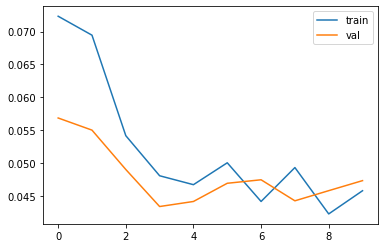

In [37]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()

In [38]:
batch = build_batch("test", batch_size=1)
print(f"{src_language}: {src_lang.tensor_to_sentence(batch.src[0])}")
out = mt_transformer.generate(batch.src, batch.src_mask, max_tokens=11)
print(f"{target_language}: {target_lang.tensor_to_sentence(out[0])}")

eng: SOS i am free UNK o clock this evening . EOS PAD
fra: SOS PAD vieille . . pas de . ici . EOS
